In [1]:
import matplotlib.pyplot as plt
import matplotlib
import geopandas
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cartopy.crs as ccrs
import numpy as np

def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

In [4]:
municipios = geopandas.read_file('deps/municipios/Municipios_IBGE.shp')

In [5]:
municipios.head()

,MSLINK,MAPID,AREA_1,PERIMETRO_,NOME,SEDE,LATITUDESE,LONGITUDES,AREA_TOT_G,Cod_ibge,Label_N,geometry
0,4985,99,118.280,61.626,HERVEIRAS,1,-29.407,-52.653,118.280,4309571,Herveiras,"POLYGON ((-52.77319 -29.44486, -52.77602 -29.4..."
1,4986,99,228.849,81.715,HORIZONTINA,1,-27.626,-54.308,228.849,4309605,Horizontina,"POLYGON ((-54.39910 -27.57012, -54.38675 -27.5..."
2,4987,99,822.943,184.883,HULHA NEGRA,1,-31.404,-53.869,822.943,4309654,Hulha Negra,"POLYGON ((-53.98933 -31.55208, -53.99221 -31.5..."
3,4988,99,135.246,70.392,HUMAITA,1,-27.563,-53.974,135.246,4309704,Humaitá,"POLYGON ((-54.07227 -27.57674, -54.06089 -27.5..."
4,4989,99,193.109,70.655,IBARAMA,1,-29.419,-53.135,193.109,4309753,Ibarama,"POLYGON ((-53.26582 -29.44975, -53.26701 -29.4..."


In [6]:
producao = pd.read_excel("deps/Arrecadacao_2020.xlsx", index_col=0)
producao = producao.fillna(0)

In [7]:
mapa_arrecadacao = {
'AREIA FLUVIAL':'AREIA',
'AREIA QUARTZOSA':'AREIA',
'AREIA FLUVIA':'AREIA',
'BASALTO P/ BRITA':'BASALTO',
'BASALTO P/ REVESTIMENTO':'BASALTO',
'CALCÁRIO CALCÍTICO':'CALCÁRIO',
'CALCÁRIO DOLOMÍTICO':'CALCÁRIO',
'CALCÁRIO INDUSTRIAL':'CALCÁRIO',
'CARVÃO MINERAL':'CARVÃO',
}

In [8]:
for i in producao.columns:
    for j in mapa_arrecadacao:
        if i == j:
            producao[mapa_arrecadacao[j]] = producao[mapa_arrecadacao[j]] + producao[mapa_arrecadacao[i]]
            producao.drop(i, inplace=True, axis=1)

In [9]:
producao.head()

,ÁGATA,ÁGUA MINERAL,AMETISTA,AREIA,ARENITO,ARGILA,BASALTO,CALCÁRIO,CALCEDÔNIA,CALCITA,...,CASCALHO,CAULIM,DIABÁSIO,GIPSITA,GNAISSE,GRANITO,RIÓLITO,SAIBRO,SIENITO,TALCO
Arrecadação de CFEM 2020 (completo),,,,,,,,,,,,,,,,,,,,,
Água Santa,0.0,0.0,0.0,0.00,0.0,0.00,145554.48,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agudo,0.0,0.0,0.0,0.00,0.0,324.72,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alecrim,0.0,0.0,0.0,0.00,0.0,0.00,9258.52,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alegrete,0.0,0.0,0.0,3849.96,0.0,0.00,64241.08,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0
Alegria,0.0,0.0,0.0,0.00,0.0,0.00,13128.56,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
producao['TOTAL'] = producao.sum(axis=1)

In [11]:
for idx, row in producao.iterrows():
    if row["TOTAL"] != 0:
        print(idx, row["TOTAL"]/1000)

Água Santa 145.55448
Agudo 0.32472
Alecrim 9.25852
Alegrete 68.09164000000001
Alegria 13.12856
Alvorada 1.27723
Amaral Ferrador 4.9524799999999995
Ametista do Sul 551.37827
Anta Gorda 57.9354
Antônio Prado 113.90028
Arambaré 0.22932
Arroio do Meio 1.12464
Arroio dos Ratos 6889.820600000001
Arroio Grande 7.025720000000001
Arvorezinha 53.00752
Bagé 6.970929999999999
Barão de Cotegipe 63.30068
Barra do Ribeiro 6.066020000000001
Barros Cassal 2.9797800000000003
Bento Gonçalves 865.9011999999999
Boa Vista do Buricá 24.1966
Bom Princípio 3.96792
Butiá 1286.23296
Caçapava do Sul 937.09937
Cacequi 224.32952
Cachoeira do Sul 1528.3330299999998
Camaquã 3.3719
Campo Bom 541.60316
Candelária 27.32777
Candiota 9626.21897
Canela 154.23744
Canguçu 6.90394
Canoas 1.50176
Capão do Leão 239.56747000000001
Capela de Santana 367.13451000000003
Capitão 26.594
Capivari do Sul 5.24848
Caraá 5.561940000000001
Carazinho 0.14944
Carlos Barbosa 75.25129000000001
Casca 144.8378
Caseiros 77.33283999999999
Caxias d

In [12]:
municipios['arrecadacao'] = 0
for index, row in producao.iterrows():
    for index1, row1 in municipios.iterrows():
        if index.upper() == row1['NOME']:
            municipios.loc[index1, 'arrecadacao'] = row['TOTAL']

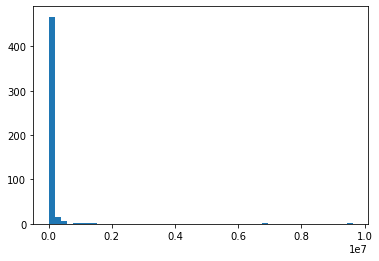

In [13]:
_ = plt.hist(municipios['arrecadacao'], cumulative=False, bins=50)

In [14]:
np.max(municipios['arrecadacao'])

9626218.97

In [15]:
municipios['ccode'] = float('nan')

In [16]:
for idx, v in enumerate(municipios['arrecadacao']):
    if v==0:
        municipios.loc[idx, 'ccode'] = 0
    if v > 0 and v < 1000:
        municipios.loc[idx, 'ccode'] = 1
    elif v >= 1000 and v < 2000:
        municipios.loc[idx, 'ccode'] = 2
    elif v >= 2000 and v < 4000:
        municipios.loc[idx, 'ccode']= 3
    elif v >= 4000 and v < 10000:
        municipios.loc[idx, 'ccode'] = 4
    elif v >= 10000 and v < 50000:
        municipios.loc[idx, 'ccode'] = 5
    elif v >= 50000 and v < 1000000:
        municipios.loc[idx, 'ccode'] = 6
    elif v >= 1000000 and v < 6000000:
        municipios.loc[idx, 'ccode'] = 7
    elif v >= 6000000 and v < np.max(municipios['arrecadacao'])+1:
        municipios.loc[idx, 'ccode'] = 8

In [17]:
#for i in municipios['ccode']:
#    print(i)

In [18]:
legenda = [
    'R$0',
    'entre 0 e 1.000',
    'entre 1.000 e 2.000',
    'entre 2.000 e 4.000',
    'entre 4.000 e 10.000',
    'entre 10.000 e 50.000',
    'entre 50.000 e 1.000.000',
    'entre 1.000.000 e 6.000.000',
    'entre 6.000.000 e 9.626.218',
]

In [19]:
lista_municipio = ['Caxias do Sul', 'Santa Maria', 'Porto Alegre', 'Pelotas']
def plot_municipios(municipios, lista_municipio, ax, c='black', delta=0.05):
    x = []
    y = []
    for index, row in municipios.iterrows():
        for m in lista_municipio:
            if row['NOME'] == m.upper():
                y.append(row['LATITUDESE'])
                x.append(row['LONGITUDES'])
    ax.scatter(x=x, y=y, marker='x', c=c)
    for i, txt in enumerate(lista_municipio[::-1]):
        ax.annotate(txt, (x[i]+delta, y[i]+delta), c=c)

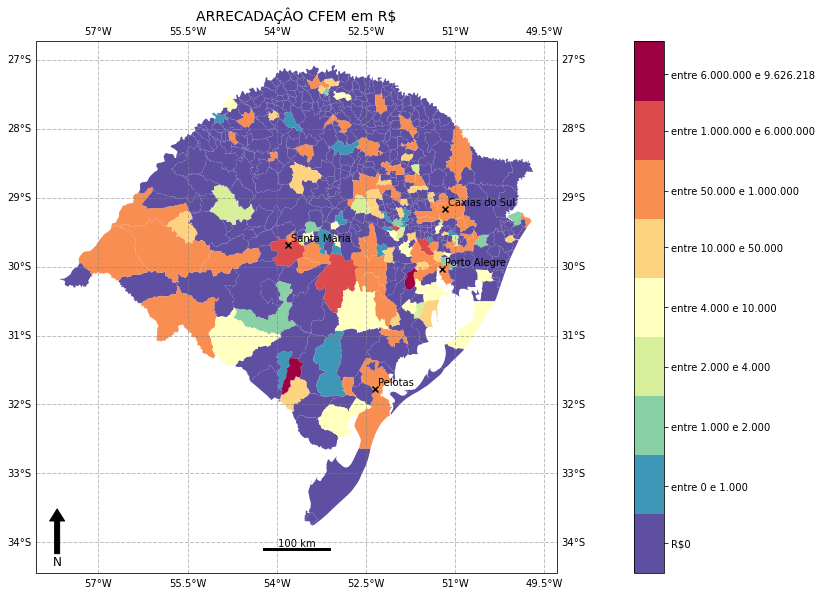

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors, cm

cmap = cm.get_cmap('Spectral_r', 9)
colorscale = cmap

fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': ccrs.PlateCarree()})
municipios.plot(ax=ax, column='ccode', edgecolor=None, legend=False, cmap=colorscale)

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.5, axes_class=plt.Axes)
vmax = municipios['ccode'].values.max()
vmin = municipios['ccode'].values.min()
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
mappable = plt.cm.ScalarMappable(cmap=colorscale, norm=norm)
fig.add_axes(ax_cb)
labels = [0.45,1.3,2.2,3.1,4,4.9,5.75,6.65,7.5]
cbar = fig.colorbar(mappable, cax=ax_cb, ticks=labels)
cbar.ax.set_yticklabels(legenda)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

x, y, arrow_length = 0.04, 0.12, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
arrowprops=dict(facecolor='black', width=5, headwidth=15),
ha='center', va='center', fontsize=12,
xycoords=ax.transAxes)

scale_bar(ax, 100, location=(0.5,0.01))

plot_municipios(municipios, lista_municipio, ax, c='black', delta=0.05)

ax.set_title('ARRECADAÇÂO CFEM em R$', loc='center', fontsize='14')
plt.savefig('imagens/arrecadacao.png', bbox_inches='tight', facecolor='white', dpi = 300, bbox_extra_artists=([ax]))

In [21]:
idh = pd.read_csv('deps/idh_rs.csv', encoding='latin1', delimiter=';')

In [22]:
idh['cfem'] = float('nan')

In [23]:
idh['idh'] = np.where(idh['idh']=='-', float('nan'), idh['idh'])

In [24]:
idh['idh'] = pd.to_numeric(idh['idh'])

In [25]:
idh.head()

,municipio,idh,cfem
0,Aceguá,0.687,NaN
1,Água Santa,0.750,NaN
2,Agudo,0.694,NaN
3,Ajuricaba,0.753,NaN
4,Alecrim,0.672,NaN


In [26]:
producao.head()

,ÁGATA,ÁGUA MINERAL,AMETISTA,AREIA,ARENITO,ARGILA,BASALTO,CALCÁRIO,CALCEDÔNIA,CALCITA,...,CAULIM,DIABÁSIO,GIPSITA,GNAISSE,GRANITO,RIÓLITO,SAIBRO,SIENITO,TALCO,TOTAL
Arrecadação de CFEM 2020 (completo),,,,,,,,,,,,,,,,,,,,,
Água Santa,0.0,0.0,0.0,0.00,0.0,0.00,145554.48,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145554.48
Agudo,0.0,0.0,0.0,0.00,0.0,324.72,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,324.72
Alecrim,0.0,0.0,0.0,0.00,0.0,0.00,9258.52,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9258.52
Alegrete,0.0,0.0,0.0,3849.96,0.0,0.00,64241.08,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,68091.64
Alegria,0.0,0.0,0.0,0.00,0.0,0.00,13128.56,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13128.56


In [27]:
for idx, row in producao.iterrows():
    municipio_cfem = idx
    #print(idx)
    for idx1, row1 in idh.iterrows():
        municipio_idh = row1['municipio']
        
        if municipio_cfem == municipio_idh:
            idh.loc[idx1, 'cfem'] = row['TOTAL']

In [28]:
idh = idh.dropna()

In [29]:
idh.head()

,municipio,idh,cfem
1,Água Santa,0.750,145554.48
2,Agudo,0.694,324.72
4,Alecrim,0.672,9258.52
5,Alegrete,0.740,68091.64
6,Alegria,0.695,13128.56


In [30]:
ma = np.nanmax(idh['idh'])
mi = np.nanmin(idh['idh'])

In [31]:
xt = np.linspace(mi,ma, 10)

In [32]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(idh['idh'].values.reshape(-1, 1), idh['cfem'].values.reshape(-1, 1))

r_sq = model.score(idh['idh'].values.reshape(-1, 1), idh['cfem'].values.reshape(-1, 1))
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.000369208620948247
intercept: [-57410.20572562]
slope: [[387511.18161367]]


In [33]:
def yval(x, a, b):
    return a*x+b

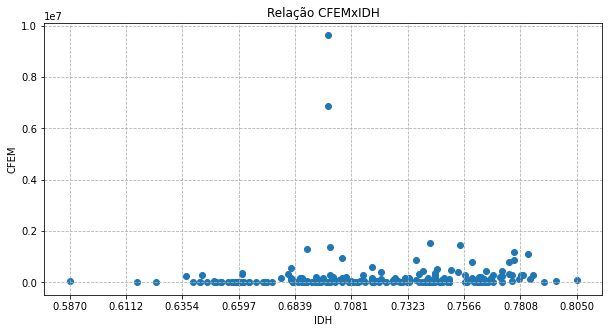

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(idh['idh'], idh['cfem'])
#plt.plot([mi,yval(mi,model.coef_ ,model.intercept_)], [ma,yval(ma,model.coef_ ,model.intercept_)], c='red')
plt.title('Relação CFEMxIDH')
plt.ylabel('CFEM')
#plt.ylim([0,0.2*1e7])
plt.xlabel('IDH')
plt.xticks(xt)
plt.grid(linestyle='--')
#plt.show()
plt.savefig('imagens/cfem_idh.png', bbox_inches='tight', facecolor='white', dpi = 300)